# Nootropics

Welcome to the wonderful world of nootropics, where no task is ever too demanding!

# How to use this notebook

The code presented in this notebook has been boiled down to as few function calls as possible to make it as easy for the reader to play with the parameters which we have been attempting to optimise in the process of cleaning and evaluating the data.

## The code

The underlying code can be found in two packages, residing in their respective folders:

* `library_functions`
* `wojciech`

## The data

The *raw* data is placed in the folder:

 `wikipedia_data`

 The cleaned data is placed in the folder:

 `shared_data`


# Requirements:

The code is based on following packages

```
plotly, version 4.12.0
pandas, version 1.1.1
spacy, version 2.3.2
infomap, version 1.2.1
regex, version 2020.7.14
ipywidgets, version 7.5.1
tqdm, version 4.50.0
python_louvain, version 0.14
wikipedia, version 1.4.0
textblob, version 0.15.3
fa2, version 0.3.5
numpy, version 1.19.2
wordcloud, version 1.8.0
networkx, version 2.5
matplotlib, version 3.3.2
powerlaw, version 1.4.6
beautifulsoup4, version 4.9.3
community, version 1.0.0b1
ipython, version 7.19.0
mediawiki, version 0.0.1
project, version 20
psaw, version 0.0.12
```

Additionally, for the `spaCy` package, we will need the `en_core_web_sm` language module, which can downloaded by running:

In [ ]:
# !python -m spacy download en_core_web_sm

## Imports

In [1]:
from library_functions.imports_explainer_notebook import *

# Data Collection

This is the part where the genius of Luca will flourish like a flower after a long winter's sleep.

# Graph creation

We will be modelling the Wikipedia graph as a directional graph, and the Reddit graph as an undirectional graph. For easier comparison of the graphs, we have decided to use the __names of substances regarded as nootropics on Wikipedia__ as nodes for both the Wikipedia and the Reddit network.

## Wikipedia

### Nodes

The __*nodes*__ in the Wikipedia network will have the following attributes:

* `categories`: a list of categories to which the substance belongs on Wikipedia, e.g. `stimulant`.

* `content`: the clean content of the substance's Wikipedia page.

* `url`: the url of the substance's Wikipedia page.

### Edges

The __*edges*__ in the Wikipedia network will have the following attributes:

* `count`: Number of occurrences of the edge (sometimes a link appears multiple times in the same page).

### Code

To create the Wikipedia graph, run the following code:

In [2]:
g_wiki = lf.create_graph_wiki()

## Reddit

### Nodes

As mentioned above, the **_nodes_** of the Reddit graph are the same as nodes of the Wikipedia graph. Their attributes, however, are different, and consist of:

* `categories`: a list of categories to which the substance belongs on Wikipedia, e.g. `stimulant`.

* `count`: The number of Reddit posts in which the substance is mentioned.

* `polarity`: a list where each element represents a measure of positivity of sentiment of a post in which the substance is mentioned. The polarity ranges from -1 to 1, where -1 represents a completely negative sentiment, and +1 completely positive sentiment.

* `subjectivity`: a list where each element represents a measure of subjectivity of a post in which the substance is mentioned. The subjectivity ranges from 0 to 1, where 0 represents a completely factual post, and 1 completely subjective opinion.

* `content` (optional): a list where each element represents contents (text) of a post in which the substance is mentioned.

### Edges

The __*edges*__ of the Reddit network will have following attributes:

* `count`: The number of Reddit posts in which the linked substances are mentioned.

* `number_of_drugs_in_post`: a lit where each element represents the number of substances mentioned in the Reddit post in which the linked substances occur.

* `polarity`: a list where each element represents a measure of positivity of sentiment of a post in which the substance is mentioned. The polarity ranges from -1 to 1, where -1 represents a completely negative sentiment, and +1 completely positive sentiment.

* `subjectivity`: a list where each element represents a measure of subjectivity of a post in which the substance is mentioned. The subjectivity ranges from 0 to 1, where 0 represents a completely factual post, and 1 completely subjective opinion.

* `content` (optional): a list where each element represents contents (text) of a post in which the substance is mentioned.

### Tweakable parameters

The graph is created using the function `lf.create_graph_reddit`. In the input of this function, the user can specify a number of constraints that will affect the creation of the graph. The tweakable parameters are:

* `max_drugs_in_post`: a maximum accepted drugs in a post. The Reddit posts containing more drugs will be disregarded. This parameter can be used to filter out posts containing entire lists of drugs, and thus do not reveal much useful information about a possible connection between specific substances.

* `min_edge_occurrences_to_link`: a limit describing the minimum number times a link needs to appear in order to be considered valid. The links that occur less times will be disregarded. This parameter can be used to filter out seldom occurring links.

* `min_content_length_in_characters`: a limit describing the minimum allowabgle length of the content of the Reddit post. Posts with shorter content will be disregarded. This parameter can be used to filter out posts with very short content.

* `conditional_functions_dict`: a dictionary keyed by attribute names whose values are functions that represent conditions for those attributes, e.g.:

 ```
 conditions = {'polarity': lambda x: x > 0.1,
               'subjectivity': lambda x: < 0.2}
 ```
 
 This parameter can be used to create a graph based on the values of a certain attribute, or a combination of attributes, e.g. a graph of substances connected in posts with a positive sentiment.

* `include_node_contents`: A boolean determining whether to assign the content of the posts containing a drug as a node attribute. This parameter can be used to reduce the amount of data stored in RAM and shorten up the processing time.

* `include_link_contents`: A boolean determining whether to assign the content of the posts containing a drug as a edge attribute. This parameter can be used to reduce the amount of data stored in RAM and shorten up the processing time

### Code

To create the Reddit graph, run the following code:

In [8]:
g_reddit = lf.create_graph_reddit(
    max_drugs_in_post=10,
    min_edge_occurrences_to_link=3,
    min_content_length_in_characters=25,
    conditional_functions_dict=None,
    include_node_contents=False,
    include_link_contents=False,
    show_progress_bars=False
)

We invite the reader to create an alternative graph using their own constraints. We will use compare that graph to our graph later in the notebook:

In [9]:
g_reddit_reader = lf.create_graph_reddit(
    max_drugs_in_post=10,
    min_edge_occurrences_to_link=3,
    min_content_length_in_characters=25,
    conditional_functions_dict={'polarity': lambda x: x > 0.15},
    include_node_contents=False,
    include_link_contents=False,
    show_progress_bars=False
)

# Network evaluation

In this chapter, we will zoom in on specific properties of the created networks, compare them, and attempt to interpret our findings.


## Degree distribution

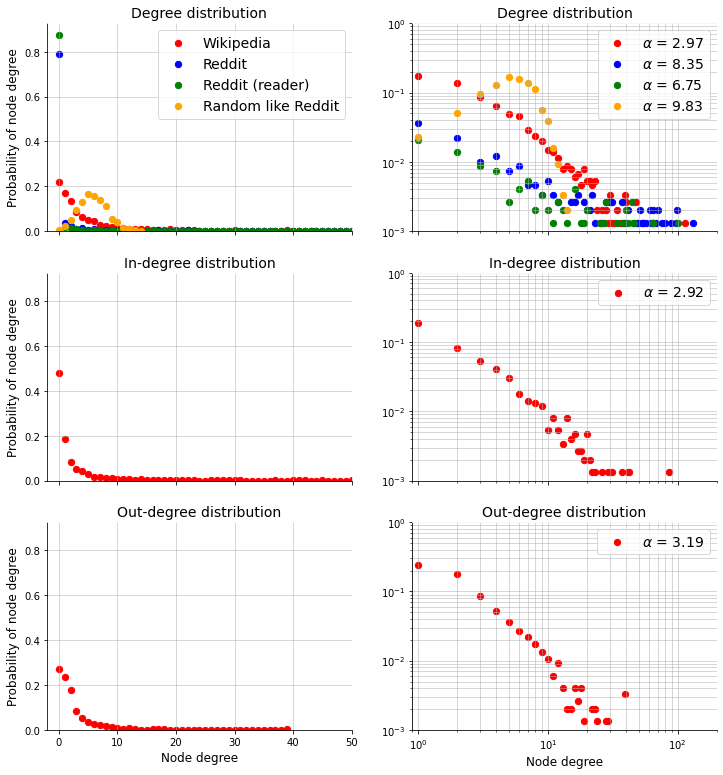

In [10]:
# Create a random network with the same degree probability as the g_reddit network
random_like_g_reddit = w.graph.erdos_renyi_like(g_reddit)

# Define the properties of the graphs to compare
graphs_to_show = [g_wiki, g_reddit, g_reddit_reader, random_like_g_reddit]
graph_names = ["Wikipedia", "Reddit", "Reddit (reader)", "Random like Reddit"]
graph_colors = ["red", "blue", "green", "orange"]

# Plot the comparison of the degree distribution
all_axes = w.graph.plot_degree_distribution_summary(
    graphs_to_show,
    graph_names=graph_names,
    graph_colors=graph_colors,
    x_lim_lin=(-2, 50),
    x_lim_log=(0.9, 200)
)

We can see in the figure above that both the Wikipedia and the Reddit networks have highly connected nodes, and that variance of the degrees of their nodes is much higher that the variance of a comparable random network. However, only the Wikipedia network exhibits the scale-free property with $\alpha$ just under 3.

## Most connected nodes

In [ ]:
# Define the number of nodes to show in the tables
n_results = 5

### Wikipedia

In [ ]:
# Define the centrality measures to investigate
centrality_measures = \
    ["degree", "in-degree", "out-degree", "betweenness", "eigenvector"]

# Show the most central nodes
most_central_nodes_wiki = w.graph.most_central_nodes(
    g_wiki, centrality_measures, n=n_results, as_pandas=True, printout=True)


### Reddit

In [ ]:
# Define the centrality measures to investigate
centrality_measures = ["degree", "betweenness", "eigenvector"]

# Show the most central nodes
most_central_nodes_reddit = w.graph.most_central_nodes(
    g_reddit, centrality_measures, n=n_results, as_pandas=True, printout=True)

### Reddit (reader)

In [ ]:
# Show the most central nodes
most_central_nodes_reddit_reader = w.graph.most_central_nodes(
    g_reddit_reader, centrality_measures, n=n_results, as_pandas=True, printout=True)

# Discussion